# CARA: robust annotation and discovery of novel cell types in single-cell ATAC-seq data through cross-modal reference alignment
This notebook implements the CARA workflow for analyzing single-cell RNA-seq and ATAC-seq data. 

In [ ]:
# Standard library imports
import os
import time as tm
import warnings

# Third-party imports
import numpy as np
import torch
import matplotlib.pyplot as plt
import anndata as ad
import pyro
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import ExponentialLR

# Local imports
from util.util import *
from util.dataloader import *
from util.detection import *
from model.model import cara

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

## Configuration

Set up hyperparameters and file paths. Modify these values according to your environment.

In [ ]:
class Config:
    # Data Paths
    # Use relative paths for portability

    RNA_PATH = "datapath/filteredrna.h5ad"
    ATAC_PATH = "datapath/filteredatac.h5ad"
    OUTPUT_PATH = os.path.join("output", "kidney")
    PREFIX = "kidney_1127"
    
    # Model Hyperparameters
    HIDDEN_SIZE = 200
    NO_CLASS = 13        # Total number of classes
    
    # Training Hyperparameters
    SEED = 233
    LEARNING_RATE = 1e-4
    DECAY_RATE = 0.97
    BATCH_SIZE = 60
    WARMUP_EPOCHS = 40
    EPOCHS = 100
    PATIENCE = 50
    
    # Other settings
    USE_CUDA = True
    NUM_WORKERS = 0
    SAVE_MODEL = False
    
    # Pyro settings
    ENUM_DISCRETE = "parallel"
    CONFIG_ENUM = "parallel"

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_PATH, exist_ok=True)

# Set random seed for reproducibility
setup(Config.SEED)

# Check CUDA availability
cuda = Config.USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Preprocessing

Load RNA and ATAC data, preprocess, and align features.

In [3]:
labeled_rna_trainloader, test_rna_loader_all, labeled_atac_trainloader, unlabeled_atac_trainloader, atac_test_loader, index_to_category, batch_num, dataset, data = load_and_process_data(Config)

Loading ATAC data from /home/yingwang/cl/oodbenchmark/hys/filteredatac.h5ad...
Finding HVGs for RNA data...
Finding HVGs for ATAC data...

Number of RNA HVGs: 3000
Number of ATAC HVGs: 3000
Total number of unique HVGs in union: 6000

Converting RNA data to DataFrame for reshaping...
Converting ATAC data to DataFrame...

Aligning RNA data using reindex (filling missing genes with 0)...
Aligning ATAC data using reindex (filling missing genes with 0)...

Converting aligned DataFrames back to AnnData objects...

--- Verification ---
Final RNA data shape: (19981, 6000)
Final ATAC data shape: (24201, 6000)

Success! 'rna_final' and 'atac_final' now have identical and ordered features.
Data alignment complete.
DataLoaders created.


## Model Initialization

Initialize the TRE model and optimizer.

In [ ]:
input_size_rna = dataset['rna_train_labeled_dataset'].data.shape[1]
input_size_atac = dataset['atac_train_labeled_dataset'].data.shape[1]
output_size_rna = Config.NO_CLASS

cara = cara(
    output_size=output_size_rna,
    rna_input_size=input_size_rna,
    atac_input_size=input_size_atac,
    z_dim=Config.HIDDEN_SIZE, 
    hidden_layers=[500],
    batch_num=batch_num,
    use_cuda=cuda,
    config_enum=Config.ENUM_DISCRETE,
    use_class_weights=True,
    aux_loss_multiplier=50,
    alpha=0.001,
)

# Setup optimizer
adam_params = {'lr': Config.LEARNING_RATE, 'betas': (0.99, 0.999), 'weight_decay': 1e-4}
optimizer = torch.optim.Adam
scheduler = ExponentialLR({'optimizer': optimizer, 'optim_args': adam_params, 'gamma': Config.DECAY_RATE})

pyro.clear_param_store()

# Setup losses
guide = config_enumerate(cara.guide, Config.ENUM_DISCRETE, expand=True)
elbo = TraceEnum_ELBO(max_plate_nesting=1, strict_enumeration_warning=False)
loss_basic = SVI(cara.model, guide, scheduler, loss=elbo)

losses = [loss_basic]
aux_loss = True
if aux_loss:
    elbo_aux = Trace_ELBO()
    loss_aux = SVI(cara.model_classify, cara.guide_classify, scheduler, loss=elbo_aux)
    losses.append(loss_aux)

## Training


Starting RNA Warmup...
Epoch 1: Loss 3102.3144
Epoch 2: Loss 2815.6523
Epoch 3: Loss 2718.8806
Epoch 4: Loss 2664.3794
Epoch 5: Loss 2623.1369
Epoch 6: Loss 2590.6861
Epoch 7: Loss 2564.6679
Epoch 8: Loss 2542.8725
Epoch 9: Loss 2524.2505
Epoch 10: Loss 2507.7191
Epoch 11: Loss 2493.1888
Epoch 12: Loss 2479.5278
Epoch 13: Loss 2467.7306
Epoch 14: Loss 2456.9506
Epoch 15: Loss 2446.7604
Epoch 16: Loss 2437.1261
Epoch 17: Loss 2428.6981
Epoch 18: Loss 2420.6862
Epoch 19: Loss 2413.5641
Epoch 20: Loss 2406.9653
Epoch 21: Loss 2400.8651
Epoch 22: Loss 2395.1561
Epoch 23: Loss 2389.3772
Epoch 24: Loss 2383.7750
Epoch 25: Loss 2378.5439
Epoch 26: Loss 2373.5760
Epoch 27: Loss 2368.1412
Epoch 28: Loss 2362.9912
Epoch 29: Loss 2358.2535
Epoch 30: Loss 2353.0742
Epoch 31: Loss 2348.0906
Epoch 32: Loss 2343.0952
Epoch 33: Loss 2338.4717
Epoch 34: Loss 2333.6182
Epoch 35: Loss 2328.8167
Epoch 36: Loss 2324.1289
Epoch 37: Loss 2319.6754
Epoch 38: Loss 2314.8467
Epoch 39: Loss 2310.2021
Epoch 40: L

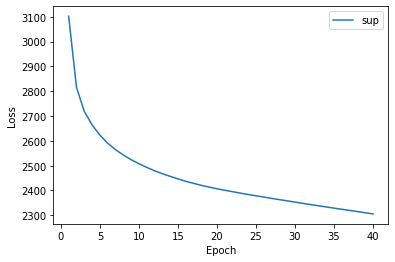

In [ ]:
print("Starting RNA Warmup...")
cara.compute_initial_class_weights(labeled_rna_trainloader)

best_valid_acc = 0.0
tr_start = tm.time()
supplosses = []

for i in range(Config.WARMUP_EPOCHS):
    ep_tr_start = tm.time()
    sup_num = len(labeled_rna_trainloader.dataset)
    
    epoch_losses_sup = run_inference_for_epoch_warmup(labeled_rna_trainloader, losses, cuda)
    avg_epoch_losses_sup = [loss / sup_num for loss in epoch_losses_sup]
    supplosses.append(avg_epoch_losses_sup[0])
    
    # Validation
    validation_accuracy, validation_f1_macro, _, _, _, _, ARI, NMI = get_accuracy(
        test_rna_loader_all, cara.classifier
    )
    
    ep_tr_time = tm.time() - ep_tr_start
    print(f"Epoch {i+1}: Loss {avg_epoch_losses_sup[0]:.4f}")
    
    if validation_accuracy > best_valid_acc:
        best_valid_acc = validation_accuracy

print(f"RNA Warmup Done. Best Val Acc: {best_valid_acc:.4f}")

# Plot Loss
plt.figure()
plt.plot(range(1, len(supplosses) + 1), supplosses, label='sup')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
# Freeze classifier
freeze_classifier(cara)
cara.compute_initial_class_weights(labeled_atac_trainloader)

supplosses = []
best_valid_acc = 0.0

print("Starting ATAC Training...")
for i in range(Config.EPOCHS):
    ep_tr_start = tm.time()
    sup_num = len(labeled_atac_trainloader.dataset)
    unsup_num = len(unlabeled_atac_trainloader.dataset)
    
    epoch_losses_sup, epoch_losses_unsup = run_inference_for_epoch(
        losses, labeled_atac_trainloader, unlabeled_atac_trainloader, cuda
    )
    
    avg_loss_sup = epoch_losses_sup[0] / sup_num
    supplosses.append(avg_loss_sup)
    
    # Validation
    validation_accuracy, _, _, _, _, _, ARI, NMI = get_accuracy(
        atac_test_loader, cara.classifier
    )
    
    print(f"Epoch {i+1}: Loss {avg_loss_sup:.4f}")
    
    if validation_accuracy > best_valid_acc:
        best_valid_acc = validation_accuracy
        
print(f"ATAC Trainng Done. Best Val Acc: {best_valid_acc:.4f}")

Starting ATAC Training...


Epoch 1: Loss 1552.8602
Epoch 2: Loss 896.1115
Epoch 3: Loss 670.1391
Epoch 4: Loss 522.9673
Epoch 5: Loss 422.7751
Epoch 6: Loss 354.0822
Epoch 7: Loss 299.0448
Epoch 8: Loss 257.6891
Epoch 9: Loss 224.8244
Epoch 10: Loss 202.3158
Epoch 11: Loss 188.1772
Epoch 12: Loss 177.3973
Epoch 13: Loss 169.4450
Epoch 14: Loss 164.2393
Epoch 15: Loss 159.4612
Epoch 16: Loss 155.9876
Epoch 17: Loss 153.3271
Epoch 18: Loss 151.0722
Epoch 19: Loss 149.7035
Epoch 20: Loss 147.8245
Epoch 21: Loss 146.5899
Epoch 22: Loss 144.7231
Epoch 23: Loss 144.6462
Epoch 24: Loss 143.4043
Epoch 25: Loss 142.3691
Epoch 26: Loss 141.6838
Epoch 27: Loss 140.9363
Epoch 28: Loss 140.2698
Epoch 29: Loss 139.6304
Epoch 30: Loss 138.8553
Epoch 31: Loss 138.6771
Epoch 32: Loss 137.7882
Epoch 33: Loss 137.5702
Epoch 34: Loss 137.5431
Epoch 35: Loss 137.3032
Epoch 36: Loss 136.8851
Epoch 37: Loss 136.6709
Epoch 38: Loss 136.3046
Epoch 39: Loss 136.2630
Epoch 40: Loss 136.0979
Epoch 41: Loss 135.3802
Epoch 42: Loss 135.4055


## Evaluation and Visualization

Visualize the results using UMAP.

 test accuracy 0.9548 F1 0.9031(macro) 0.9523(weighted) precision 0.9661 recall 0.8641 mcc 0.9395 ARI 0.9218 NMI 0.8792


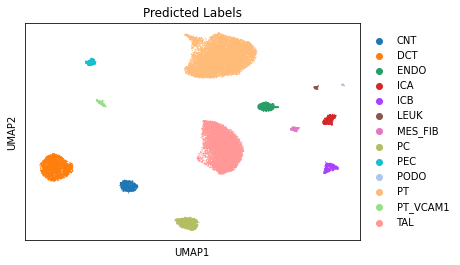

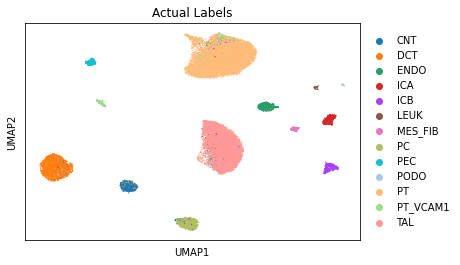

accuracy:0.9548, precision_macro:0.9661, precision_weighted:0.9559, recall_macro:0.8641, recall_weighted:0.9548, f1_macro:0.9031, f1_weighted:0.9523, ARI:0.9218, NMI:0.8792, jaccard:0.8358, fm:0.9422, v_measure:0.8792, purity:0.9548


{'accuracy': 0.9548136645962733,
 'precision_macro': 0.9660527086565653,
 'precision_weighted': 0.9558571543374166,
 'recall_macro': 0.864129664726365,
 'recall_weighted': 0.9548136645962733,
 'f1_macro': 0.9031128957105291,
 'f1_weighted': 0.952257082885578,
 'ARI': 0.9217617154089901,
 'NMI': 0.8792138570269973,
 'jaccard': 0.8357980762424473,
 'fm': 0.9422316413895016,
 'v_measure': 0.8792138570269973,
 'purity': 0.9548136645962733}

In [ ]:
# Save model
if Config.SAVE_MODEL:
    save_path = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}.pkl")
    torch.save(cara.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# Final Evaluation
predictions, scores, actuals, zs, zys, batchs, exps, barcodes, elbo_loss, metrics = evaluate(atac_test_loader, cara, loss_basic)


testadata = data['ATACCE_test'][barcodes, :].copy()
testadata.obsm["embedding"] = zys
testadata.obsm['prob'] = scores
testadata.obs['elbo_loss'] = elbo_loss[:testadata.shape[0],:]

# UMAP Visualization
sc.pp.neighbors(testadata, use_rep="embedding", n_neighbors=30)
sc.tl.umap(testadata, min_dist=0.3)

# Map predictions to names
testadata.obs['predictions'] = map_indices_to_names([index[0] for index in predictions], index_to_category)

# Plot Predictions
sc.pl.umap(testadata, color=['predictions'], show=False, title="Predicted Labels")
outputfig1 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_predict_label.pdf")
plt.savefig(outputfig1, format="pdf")
plt.show()

# Plot Actual Labels
sc.pl.umap(testadata, color=['cell_type'], show=False, title="Actual Labels")
outputfig2 = os.path.join(Config.OUTPUT_PATH, f"{Config.PREFIX}_actual_label.pdf")
plt.savefig(outputfig2, format="pdf")
plt.show()

# Compute Metrics
groundtruth = testadata.obs['cell_type']
originalcell = testadata.obs['predictions']
compute_metrics(groundtruth, originalcell)